# Lattice computations

In [1]:
%matplotlib inline
import openmc
import numpy as np
from IPython.display import Image

In this section, we will build one of the assemblies from the BEAVRS benchmark.  This is a PWR assembly with fuel pins, guide tubes, and borosilicate glass burnable poisons.  A diagram of th assembly is plotted below.  To make it a little easier (and improve our statistics!) we will only build one quarter of it.

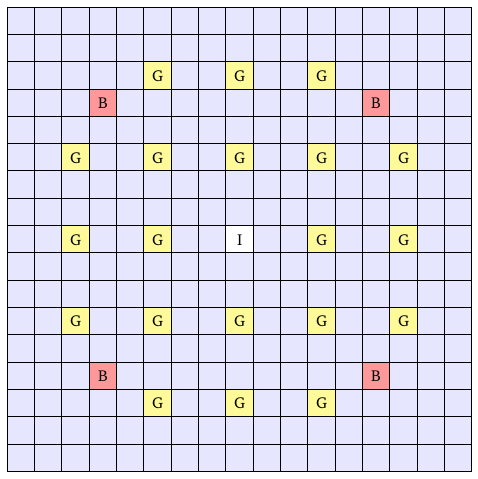

In [2]:
Image('assembly_diagram.png')

## Materials

Again we have UO2, Zr, and H2O.  We also have borosilicate glass (pyrex).  This time we'll use the shortcut for defining enriched uranium.

In [3]:
uo2 = openmc.Material(name='uo2')
uo2.add_element('U', 1.0, enrichment=3.0)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material(name='zirconium')
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2)
water.add_nuclide('O16', 1)
water.set_density('g/cm3', 0.7)
water.add_s_alpha_beta('c_H_in_H2O')

pyrex = openmc.Material(name='pyrex')
pyrex.add_element('B', 0.49)
pyrex.add_element('O', 4.7)
pyrex.add_element('Al', 0.17)
pyrex.add_element('Si', 1.8)
pyrex.set_density('g/cm3', 2.26)

In [4]:
mf = openmc.Materials((uo2, zirconium, water, pyrex))
mf.export_to_xml()

Later in this example, we will make a bunch of geometry plots.  By default, every region is colored randomly and the results are Now that we know our materials, let's define a "color specification" to use when plotting our geometry.

In [5]:
colors = {}
colors[water] = 'lightblue'
colors[zirconium] = 'gray'
colors[pyrex] = 'green'
colors[uo2] = 'red'

## Fuel pin

This is similar to the pincell example, but we don't have boundary conditions.  This `fuel_pin` universe extends to infinity

In [6]:
pitch = 1.26

fuel_or = openmc.ZCylinder(R=0.39)
clad_ir = openmc.ZCylinder(R=0.40)
clad_or = openmc.ZCylinder(R=0.46)

fuel = openmc.Cell(name='fuel', fill=uo2)
fuel.region = -fuel_or

gap = openmc.Cell(name='air gap')
gap.region = +fuel_or & -clad_ir

clad = openmc.Cell(name='clad', fill=zirconium)
clad.region = +clad_ir & -clad_or

moderator = openmc.Cell(name='moderator', fill=water)
moderator.region = +clad_or

fuel_pin = openmc.Universe(cells=(fuel, gap, clad, moderator))

When building a complex geometry, it is helpful to plot each universe as you go along.  Let's plot this pincell now

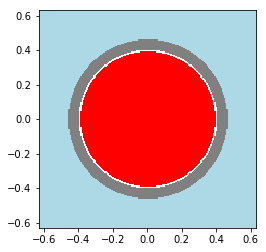

In [7]:
fuel_pin.plot(width=(pitch, pitch), color_by='material',
              colors=colors)

## Guide tube

In [8]:
clad_ir = openmc.ZCylinder(R=0.56)
clad_or = openmc.ZCylinder(R=0.60)

inner = openmc.Cell(fill=water, region=-clad_ir)
clad = openmc.Cell(fill=zirconium, region=+clad_ir & -clad_or)
outer = openmc.Cell(fill=water, region=+clad_or)

guide_tube = openmc.Universe(cells=(inner, clad, outer))

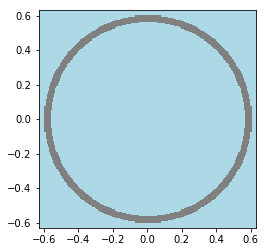

In [9]:
guide_tube.plot(width=(pitch, pitch), color_by='material',
                colors=colors)

## Pyrex burnable poison

In [10]:
# Define the cylinders which bound each radial zone.
radii = [0.21, 0.23, 0.24, 0.43, 0.44, 0.48, 0.56, 0.60]
cyls = [openmc.ZCylinder(R=R) for R in radii]

# Initialize a list of cells.
bp_cells = []

# Define the inner void zone first.
c = openmc.Cell(region=-cyls[0])
bp_cells.append(c)

# Now all the sandwiched layers.
mats = [zirconium, None, pyrex, None, zirconium, water, zirconium]
for i, mat in enumerate(mats):
    c = openmc.Cell(
        fill=mat,
        region = +cyls[i] & -cyls[i+1]
    )
    bp_cells.append(c)

# And the outer moderator region.
c = openmc.Cell(fill=water, region = +cyls[-1])
bp_cells.append(c)

# Make a universe containing these cells
burn = openmc.Universe(cells=bp_cells)

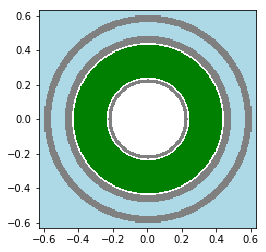

In [11]:
burn.plot(width=(pitch, pitch), color_by='material',
          colors=colors)

## Lattices in OpenMC

OpenMC has `RectLattice` and `HexLattice` objects.  This demo will use a `RectLattice`.  Let's look at a simple one before we do the quarter assembly.

First, we also need to define a universe that is all water.

In [12]:
moderator = openmc.Cell(fill=water)
all_water = openmc.Universe(cells=[moderator])

In [13]:
lattice = openmc.RectLattice()

# First we specify the dimension---the number of lattice tiles in x and y.
lattice.dimension = (2, 2)

# Next are the xy-coordiantes of the lower-left corner of the lattice.
lattice.lower_left = (0., 0.)

# Next is the pitch---the size of the lattice tiles in each direction.
lattice.pitch = (pitch, pitch)

# Now we specify what is actually inside the lattice.  This 2D lattice will be a
# list of lists like
# lattice.universes = [ [a1, a2, ...], [b1, b2, ...], ...]
# The inner lists specify columns from left to right.  The outer lists specify
# rows from top to bottom.
lattice.universes = [
    [fuel_pin,   fuel_pin],
    [guide_tube, fuel_pin]
]

# We also need to specify what is outside of the lattice.  In this case, it is
# the infinite water universe.
lattice.outer = all_water

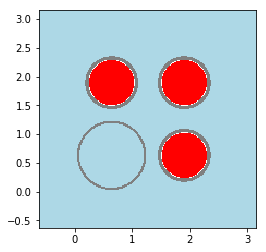

In [14]:
main = openmc.Cell(fill=lattice)
root = openmc.Universe(cells=[main])

plot_args = {
    'width': (3*pitch, 3*pitch),
    'center': (pitch, pitch, 0),
    'color_by': 'material',
    'colors': colors
}
root.plot(**plot_args)

## What exactly does `outer` mean?

We are taking that one universe and tiling it infinitely outside the lattice.

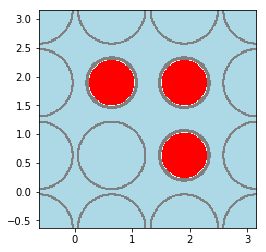

In [15]:
# Try a different outer universe to see what I mean
lattice.outer = guide_tube
root.plot(**plot_args)

## The BEAVRS assembly

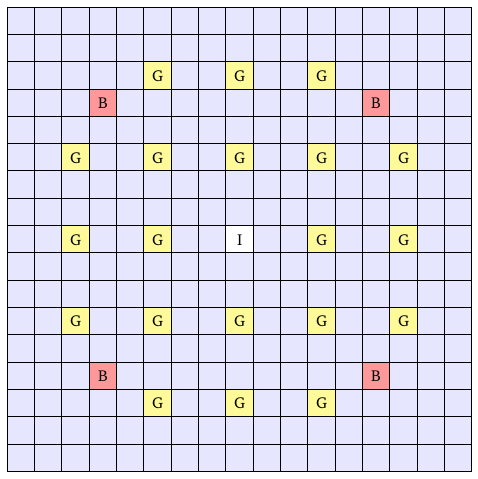

In [16]:
Image('assembly_diagram.png')

In [17]:
lattice = openmc.RectLattice()

lattice.dimension = (9, 9)
lattice.pitch = (pitch, pitch)
lattice.outer = all_water

# I want (x0, y0) = (0, 0) to be the center of the instrument tube so that means
# the lower-left will be -half a pin pitch in x and y.
lattice.lower_left = (-pitch/2, -pitch/2)

# Most of the lattice positions are fuel pins so rather than type all of those
# out, we use a list comprehension to start with a 9x9 array of fuel.
lattice.universes = [[fuel_pin for i in range(9)] for j in range(9)]

# Or we can take advantage of numpy!
lattice.universes = np.tile(fuel_pin, (9, 9))

# Then I will replace some fuel pins with guide tubes.  First index is the row,
# starting from the top, and the second is the column (like a matrix).
lattice.universes[2,0] = guide_tube
lattice.universes[2,3] = guide_tube
lattice.universes[5,0] = guide_tube
lattice.universes[5,3] = guide_tube
lattice.universes[5,6] = guide_tube
lattice.universes[8,0] = guide_tube
lattice.universes[8,3] = guide_tube
lattice.universes[8,6] = guide_tube

# And the burnable poison rod.
lattice.universes[3,5] = burn

Now we just have to add the boundary conditions and root universe to finish the geometry.

In [18]:
height = 100 # Finite height is not strictly necessary but may avoid floating-point errors
assembly_pitch = 17*pitch

x0 = openmc.XPlane(x0=0.0, boundary_type='reflective')
x1 = openmc.XPlane(x0=assembly_pitch/2, boundary_type='reflective')
y0 = openmc.YPlane(y0=0.0, boundary_type='reflective')
y1 = openmc.YPlane(y0=assembly_pitch/2, boundary_type='reflective')
z0 = openmc.ZPlane(z0=-height/2, boundary_type='reflective')
z1 = openmc.ZPlane(z0=height/2, boundary_type='reflective')

main = openmc.Cell(fill=lattice)
main.region = +x0 & -x1 & +y0 & -y1 & +z0 & -z1

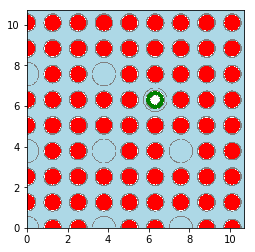

In [19]:
root = openmc.Universe(cells=(main,))
plot_args['width'] = (assembly_pitch/2, assembly_pitch/2)
plot_args['center'] = (assembly_pitch/4, assembly_pitch/4, 0)
plot_args['pixels'] = (500, 500)
root.plot(**plot_args)

In [20]:
geom = openmc.Geometry(root)
geom.export_to_xml()

In [21]:
settings = openmc.Settings()

lower_left, upper_right = main.region.bounding_box
spatial_dist = openmc.stats.Box(lower_left, upper_right)
settings.source = openmc.Source(space=spatial_dist)
settings.batches = 50
settings.inactive = 10
settings.particles = 1000
settings.verbosity = 5
settings.export_to_xml()

In [22]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tallies

Okay, that was cool, but $k_\text{eff}$ isn't everyting.  We also want to know reaction rates so we can compute the power distribution, depletion rate, etc.  If we want pin-by-pin reaction rates, we have two options.  First, we can use a tally mesh.  This will lay a rectangular grid over the geometry and tally the reaction rates in each mesh bin.

In [23]:
tallies = openmc.Tallies()

mesh = openmc.Mesh()
#mesh.dimension = lattice.dimension # Could set dimension from the lattice
mesh.dimension = [3, 3] # But we will use 3x3 for this example
mesh.lower_left = lattice.lower_left
mesh.width = lattice.pitch

mesh_filt = openmc.MeshFilter(mesh)

t = openmc.Tally(1)
t.filters = [mesh_filt]
t.scores = ['total', 'fission']
t.nuclides = ['total', 'U235']
tallies.append(t)

Or we can use something called a "distribcell" filter.  Note that the bin specifies a cell id.

In [24]:
dist_filt = openmc.DistribcellFilter(fuel.id)
t = openmc.Tally(2)
t.filters = [dist_filt]
t.scores = ['total', 'fission']
t.nuclides = ['total', 'U235']
tallies.append(t)

tallies.export_to_xml()

In [25]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [26]:
!cat tallies.out


 ============================>     TALLY 1     <============================

 Mesh Index (1, 1)
   Total Material
     Total Reaction Rate                  0.137215       +/- 4.26773E-03
     Fission Rate                         0.0            +/- 0.0
   U235
     Total Reaction Rate                  0.0            +/- 0.0
     Fission Rate                         0.0            +/- 0.0
 Mesh Index (2, 1)
   Total Material
     Total Reaction Rate                  0.220738       +/- 4.11056E-03
     Fission Rate                         4.47589E-03    +/- 2.08441E-04
   U235
     Total Reaction Rate                  5.79803E-03    +/- 2.50500E-04
     Fission Rate                         4.26045E-03    +/- 2.07607E-04
 Mesh Index (3, 1)
   Total Material
     Total Reaction Rate                  0.219389       +/- 3.02443E-03
     Fission Rate                         4.49940E-03    +/- 1.75036E-04
   U235
     Total Reaction Rate                  5.82275E-03    +/- 2.10259E-04
     Fi

## Distributed materials

In a depletion problem, every fuel pin might need its own unique material.  We have a feature called "distributed materials" which makes this easier. The idea is that we can assign a different material to each unique instance of the cell. The first thing we want to know is how many instances of a particular cell there are. We first need to call the `Geometry.determine_paths()` method which determines all the unique paths to a particular cell. 

In [27]:
geom.determine_paths()

Now each cell and material will have a `paths` attribute that tells us where the cell appears in our geometry. For example, the first five instances of the fuel are:

In [28]:
fuel.paths[:5]

['u10007->c10018->l10006(0,1)->u10000->c10000',
 'u10007->c10018->l10006(0,2)->u10000->c10000',
 'u10007->c10018->l10006(0,4)->u10000->c10000',
 'u10007->c10018->l10006(0,5)->u10000->c10000',
 'u10007->c10018->l10006(0,7)->u10000->c10000']

The order of the unique instances in the `paths` attribute also indicates the order in which we should specify materials. To specify a different material for each instance, we assign a list of materials to `fuel.fill` that is as long as the number of instances. Let's create a unique copy of UO2 for each instance and assign it to the fuel cell.

In [29]:
uo2_mats = []
for i in range(fuel.num_instances):
    m = openmc.Material(name='uo2')
    m.add_element('U', 1.0, enrichment=3.0)
    m.add_nuclide('O16', 2.0)
    m.set_density('g/cm3', 10.0)
    uo2_mats.append(m)

mf += uo2_mats
mf.export_to_xml()

Now that we have a list of materials, let's assign it to the cell and re-export our geometry.

In [30]:
fuel.fill = uo2_mats
geom.export_to_xml()

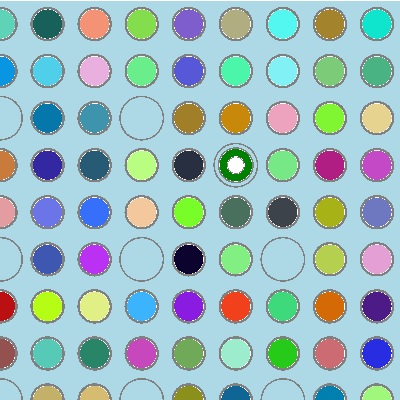

In [31]:
p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'
p.colors = plot_args['colors']

openmc.plot_inline(p)